In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from Data_handler import Data, RF_COL
from termcolor import colored

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os

# 2 Loading the data

In [121]:
# Prepare data
Data_instance = Data()               # create instance of the class Data()
data = Data_instance.get_data()      # store the data of Data_instance

Data has been loaded from local files. Only data with more than 36 observations has been kept.


In [122]:
data.sort_values(by=['permno','date'],inplace=True)
print(data.shape)

(1439408, 9)


# 3 Betting Against Beta

In [123]:
data.groupby('date').first().sort_values(by='date')

,permno,ret,shrout,prc,mcap,mcap_l,tmytm,vwretd
date,,,,,,,,
1964-01-31,10006,0.068548,2948.0,66.25,195305.00,202675.00,0.002873,0.025790
1964-02-28,10006,0.043774,2948.0,68.75,202675.00,202675.00,0.002945,0.017207
1964-03-31,10006,0.000000,2948.0,68.75,202675.00,203412.00,0.002940,0.017636
1964-04-30,10006,0.003636,2948.0,69.00,203412.00,199727.00,0.002797,0.004607
1964-05-28,10006,-0.010870,2948.0,67.75,199727.00,214835.50,0.002721,0.017403
...,...,...,...,...,...,...,...,...
2023-08-31,10028,-0.319092,26897.0,5.10,137174.70,127491.78,0.004463,-0.020605
2023-09-29,10028,-0.070588,26897.0,4.74,127491.78,105436.24,0.004472,-0.047390
2023-10-31,10028,-0.172996,26897.0,3.92,105436.24,116946.00,0.004475,-0.028867


## Question a)

In [124]:
# Add excess returns
data['Rn_e'] = data['ret'] - data[RF_COL]
data['Rm_e'] = data['vwretd'] - data[RF_COL]

# Drop nan values
data = data.dropna().copy()

# Rolling betas for each stock, based on 5-year windows (code from PS5)
w = 5 * 12  # window size
covariance = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(window=w, min_periods=36).cov()
betas = covariance.iloc[1::2,1].droplevel(2) / covariance.iloc[0::2,1].droplevel(2)
betas = betas.dropna().reset_index().rename(columns={'Rm_e': 'beta'})

# Make sure the dates columns are datetime
betas.date = pd.to_datetime(betas.date)
data.date = pd.to_datetime(data.date)

# Offset the dates of the betas by 1 month (code from PS5)
betas.date = betas.date + pd.DateOffset(months=1)

# Merge the full data with betas (code from PS5)
data_Qb = pd.merge(data, betas, on=['permno', 'date'], how='left')

# Finally, we winsorize the betas (5% and 95%) (code from PS5)
data_Qb['beta'] = data_Qb['beta'].clip(data_Qb['beta'].quantile(0.05), data_Qb['beta'].quantile(0.95))

# Drop all nan
data_Qb = data_Qb.dropna().copy()

print('Distribution of betas:')
print(data_Qb['beta'].describe(), '\n')


display(data_Qb.head()) # Overview of the data
print(data_Qb.shape)

Distribution of betas:
count    403313.000000
mean          1.128610
std           0.709878
min           0.418632
25%           0.654772
50%           0.892287
75%           1.317373
max           3.182729
Name: beta, dtype: float64 



,permno,date,ret,shrout,prc,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,beta
36,10001,2013-01-31,0.062701,8157.0,9.87,80509.59,81080.58,0.000051,0.054142,0.062650,0.054091,2.152012
37,10001,2013-02-28,0.011651,8157.0,9.94,81080.58,83201.40,0.000040,0.008282,0.011611,0.008242,2.064342
38,10001,2013-03-28,0.030684,8157.0,10.20,83201.40,86668.70,0.000034,0.035295,0.030650,0.035261,2.065339
44,10001,2013-09-30,0.004412,10372.0,10.20,105794.40,103408.84,0.000017,0.037497,0.004395,0.037480,2.084554
48,10001,2014-01-31,0.147572,10452.0,9.17,95844.84,97830.72,0.000042,-0.030020,0.147530,-0.030062,2.327879


(403313, 12)


In [125]:
# data_Qb = data.copy().dropna() # Uncomment if decide to use the class method to get the rolling betas, which gives different results 😃
print("Initial number of observations: ", data.shape[0])
print("Final number of observations: \t", data_Qb.shape[0])

Initial number of observations:  1420790
Final number of observations: 	 403313


## Question b)

### Equally weighted portfolios

In [126]:
# Create deciles based on Beta value (code from PS5)
data_Qb["EW_monthly_decile"] = data_Qb.groupby("date")["beta"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Equally weighted returns per month, for each decile
EW_returns = data_Qb.groupby(["date", "EW_monthly_decile"]).agg({
    'ret': 'mean',
    RF_COL: 'first',
    'EW_monthly_decile': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'EW_monthly_decile': 'decile'})

print("Equally weighted returns per month, for each decile:")
display(EW_returns.head(5))

Equally weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,0.056276,0.003737,0,1967-02-28
1,0.036645,0.003737,1,1967-02-28
2,0.040646,0.003737,2,1967-02-28
3,0.035698,0.003737,3,1967-02-28
4,0.034776,0.003737,4,1967-02-28


In [127]:
# Value weighted returns per month, for each decile
data_Qb['VW_weight'] = data_Qb.groupby(['date', 'EW_monthly_decile'])['mcap'].transform(lambda x: x / x.sum())
data_Qb['VW_ret_contrib'] = data_Qb['VW_weight'] * data_Qb['ret']

VW_returns = data_Qb.groupby(["date", "EW_monthly_decile"]).agg({
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'EW_monthly_decile': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'EW_monthly_decile': 'decile', 'VW_ret_contrib': 'ret'})

print("Value weighted returns per month, for each decile:")
display(VW_returns.head(5))

Value weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,0.025554,0.003737,0,1967-02-28
1,-0.001292,0.003737,1,1967-02-28
2,0.030538,0.003737,2,1967-02-28
3,0.017647,0.003737,3,1967-02-28
4,0.005232,0.003737,4,1967-02-28


### Plot the mean returns, volatility, and sharpe ratios for EW and VW portfolios

#### Auxiliary functions for plots

In [128]:
def get_mean_std_sharpe(data):
    """Compute the annulalized mean, standard deviation and Sharpe ratio for each decile."""
    mean = list(map(lambda x: 12*x, data.groupby('decile')['ret'].mean().values.tolist()))
    std = list(map(lambda x: np.sqrt(12)*x, data.groupby('decile')['ret'].std().values.tolist()))
    rf = np.mean(list(map(lambda x: 12*x, data.groupby('decile')[RF_COL].mean().values.tolist())))
    sr = list(map(lambda ret, vol: (ret - rf) / vol, mean, std))
    
    return mean, std, sr

def plot_from_lists(mean, std, sharpe, plot_color = 'blue'):
    deciles = list(range(len(mean)))

    a, axs = plt.subplots(1, 3, figsize=(25, 7), sharey=False)

    axs[0].bar(deciles, mean, color=plot_color)
    axs[0].set_title("Average portolio mean return")
    axs[0].set_xticks(deciles)
    axs[0].set_xlabel("Decile")
    axs[0].set_ylabel("Annualized return")

    axs[1].bar(deciles, std, color=plot_color)
    axs[1].set_title("Average portolio annualized standard deviation")
    axs[1].set_xticks(deciles)
    axs[1].set_xlabel("Decile")
    axs[1].set_ylabel("Annualized standard deviation")

    axs[2].bar(deciles, sharpe, color=plot_color)
    axs[2].set_title("Average portolio annualized sharpe ratio")
    axs[2].set_xticks(deciles)
    axs[2].set_xlabel("Decile")
    axs[2].set_ylabel("Annualized sharpe ratio")
    
    return plt

def plot_mean_std_sr(data, question, plot_name, show = True):
    """Takes a dataframe in input and returns a 3 graphs for the  annualized mean, std and sharpe ratio for some deciles."""

    if not os.path.exists("Figures"):
            os.makedirs("Figures")
    
    mean, std, sharpe = get_mean_std_sharpe(data)

    plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')

    if show:
        plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
        plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
        plot.show()

#### Plots

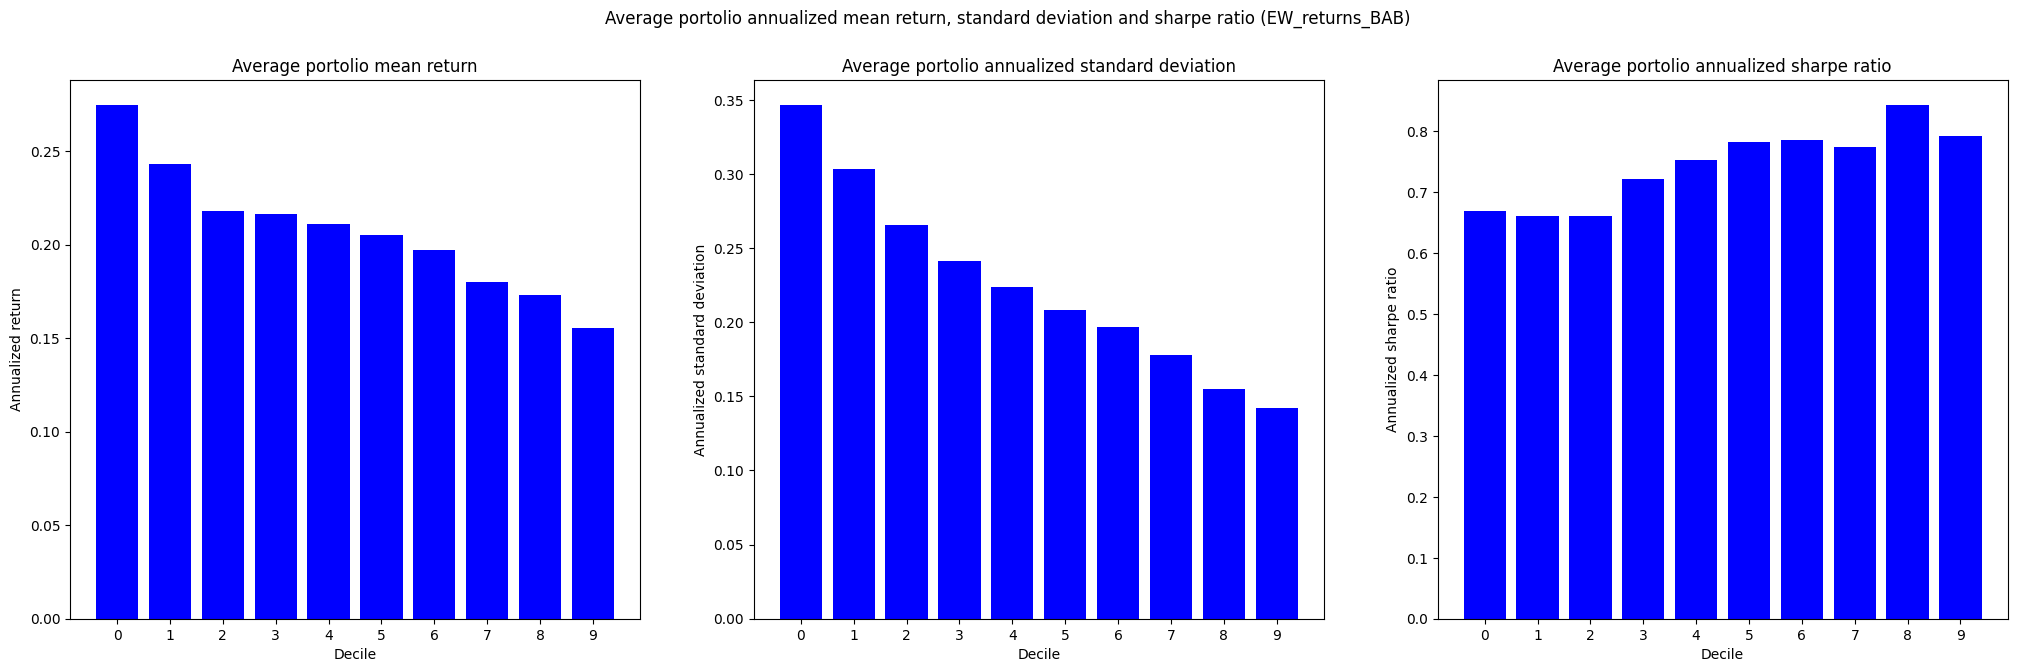

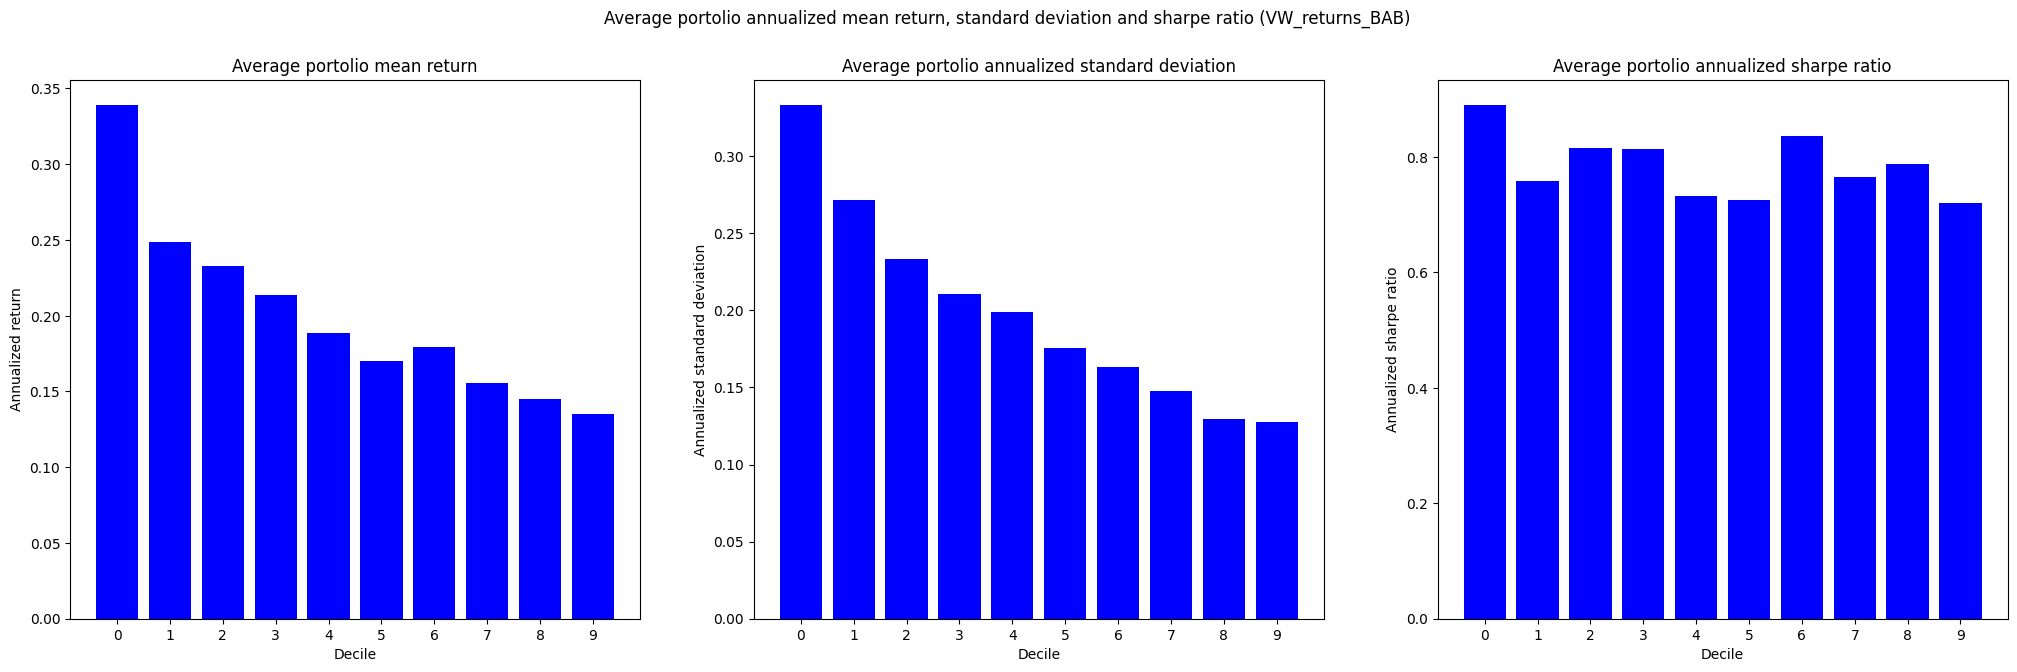

In [129]:
# Plot the results for the 2 different weightings
plot_mean_std_sr(EW_returns, '3b', "EW_returns_BAB")
plot_mean_std_sr(VW_returns, '3b', "VW_returns_BAB")

## Question c) and d)

### Built the function for determining BAB weights

In [130]:
def get_bab_weights(data):
    """Computes the weights of the Betting-Against-Beta portfolio (code inspired from PS5)."""
    df = data.copy()
    df['z'] = df.groupby('date')['beta'].rank()                     # Assign each beta a rank, for each month
    df['z_mean'] = df.groupby('date')['z'].transform('mean')        # Calculate the monthly mean the rank
    df['norm'] = np.abs(df['z']- df['z_mean'])                      # Compute abs distance of rank to mean rank
    df['sum_norm'] = df.groupby('date')['norm'].transform("sum")    # Sum the distance
    df['k'] = 2 / df['sum_norm']                                    # Compute the k

    # Compute the BAB weights
    df['wH'] = df['k'] * np.maximum(0, df['z'] - df['z_mean'])
    df['wL'] = - df['k'] * np.minimum(0, df['z'] - df['z_mean'])

    # Drop irrelevant columns
    df = df.drop(columns=["z_mean", 'z', 'norm', 'sum_norm', 'k'])

    # Compute the weighted betas
    df['bH'] = df['wH'] * df['beta']
    df['bL'] = df['wL'] * df['beta']

    # Compute the individual excess returns of the portfolios H and L
    df['rH_e'] = df['wH'] * (df['ret'] - df[RF_COL])
    df['rL_e'] = df['wL'] * (df['ret'] - df[RF_COL]) # Check that crazy formula bby 😃  (en gros, c'est okay de faire weight * excess return au lieu de faire weight * excess return?)
    
    # Compute the return and betas of the two portfolios for each period
    df_ = df.groupby('date').agg({
        'rH_e': 'sum',
        'rL_e': 'sum',
        'bH': 'sum',
        'bL': 'sum',
        'Rm_e': 'first',
    }).reset_index()

    # Finally create the BAB portfolio return
    df_['rBAB'] = df_['rL_e'] / df_['bL'] - df_['rH_e'] / df_['bH']

    return df_

In [131]:
# Create the weights rBAB
data_BAB = get_bab_weights(data_Qb)
display(data_BAB)

,date,rH_e,rL_e,bH,bL,Rm_e,rBAB
0,1967-02-28,0.027104,0.044744,1.569962,0.479699,0.007208,0.076012
1,1967-06-30,0.038647,0.119197,1.717533,0.501619,0.023813,0.215122
2,1967-08-31,0.010077,0.000893,1.665634,0.496639,-0.009498,-0.004252
3,1967-11-30,0.000182,-0.002290,1.670226,0.501153,0.004411,-0.004679
4,1968-02-29,-0.039888,-0.078032,1.810822,0.515035,-0.037518,-0.129481
...,...,...,...,...,...,...,...
241,2022-12-30,-0.042061,-0.069443,1.691482,0.551021,-0.060446,-0.101159
242,2023-02-28,-0.022986,-0.035482,1.684783,0.547142,-0.028348,-0.051207
243,2023-06-30,0.053003,0.120690,1.683151,0.546909,0.061881,0.189186
244,2023-08-31,-0.033597,-0.062400,1.682700,0.544642,-0.025068,-0.094604


### Get the return, std and sharpe ratio of the BAB strategy

In [132]:
# We compute the rf based on question b) results, as the underlying data is the same
rf = np.mean(list(map(lambda x: 12*x, VW_returns.groupby('decile')[RF_COL].mean().values.tolist())))

# Compute the return, std and Sharpe ratio of the BAB strategy
BAB_ret = data_BAB.rBAB.mean() * 12
BAB_std = data_BAB.rBAB.std() * np.sqrt(12)
BAB_shr = (BAB_ret - rf) / BAB_std

# Compute the CAPM alpha
data_BAB['one'] = 1 # Create the column for the constant
model = sm.OLS(data_BAB['rBAB'], data_BAB[['one', 'Rm_e']]).fit() # Fit CAPM

print(colored("Betting-against-beta strategy", "black", attrs=['underline', 'bold']))
print(" - Mean return: {:.2f}".format(BAB_ret))
print(" - Standard deviation: {:.2f}".format(BAB_std))
print(" - Sharpe ratio: {:.2f}".format(BAB_shr))
print(" - CAPM alpha: {:.2f}".format(model.params.iloc[0] * 12))

Betting-against-beta strategy
 - Mean return: 0.29
 - Standard deviation: 0.45
 - Sharpe ratio: 0.54
 - CAPM alpha: 0.12


# 4 Momentum Strategy

## Question a)

### Create the deciles based on the 12-month cumulative return, excluding short term reversal

In [133]:
data.sort_values(by=['permno', 'date'], inplace=True)
display(data.head())

,permno,date,ret,shrout,prc,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e
6,10001,2009-12-31,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,0.162589,0.028443
5,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,-0.018945,-0.037185
4,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,0.020531,0.063556
2,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,0.124267,0.019918


In [134]:
# Sort data by permno, then date
data_mom = data.copy()
data_mom.sort_values(by=['permno', 'date'], inplace=True)

# Add a column for momentum return (last 12 months, excluding last month)
data_mom['roll_ret'] = data_mom.groupby('permno').ret.transform(lambda x: x.rolling(11, closed='left').sum())
display(data_mom.head())

,permno,date,ret,shrout,prc,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,roll_ret
6,10001,2009-12-31,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,0.162589,0.028443,NaN
5,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,-0.018945,-0.037185,NaN
4,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,-0.000717,0.034683,NaN
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,0.020531,0.063556,NaN
2,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,0.124267,0.019918,NaN


In [135]:
# Create deciles for the momentum returns
data_mom['decile_mom'] = data_mom.groupby('date')['roll_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute the monthly return for each decile (this is the average of the individual monthly return of each stock from each decile)
data_mom['EW_monthly_return'] = data_mom.groupby(['date', 'decile_mom'])['ret'].transform('mean')

# Drop nan values
data_mom = data_mom.dropna().copy()

display(data_mom.head())
print(data_mom.shape)
# data_mom.to_csv('data_mom.csv')

,permno,date,ret,shrout,prc,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,roll_ret,decile_mom,EW_monthly_return
86,10001,2010-12-31,0.052291,7834.0,10.52,82413.68,84450.52,0.000068,0.067182,0.052223,0.067114,0.255899,6.0,0.075576
85,10001,2011-01-31,0.028992,7834.0,10.78,84450.52,86017.32,0.000125,0.019183,0.028867,0.019058,0.145569,2.0,0.027210
84,10001,2011-02-28,0.022727,7834.0,10.98,86017.32,91892.82,0.000065,0.038156,0.022662,0.038091,0.193493,4.0,0.060674
83,10001,2011-03-31,0.072404,7834.0,11.73,91892.82,91535.73,0.000049,0.003341,0.072355,0.003292,0.216876,4.0,0.018271
82,10001,2011-04-29,-0.038789,8151.0,11.23,91535.73,93736.50,0.000013,0.028597,-0.038802,0.028584,0.268637,6.0,0.020016


(1323031, 14)


### Equally weighted portfolios

In [136]:
# Equally weighted returns per month, for each decile
EW_returns_mom = data_mom.groupby(['date', 'decile_mom']).agg({
    'ret': 'mean',
    RF_COL: 'first',
    'decile_mom': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'decile_mom': 'decile'})

print(colored("Equally weighted returns per month, for each decile:", "black", attrs=['underline', 'bold']))
display(EW_returns_mom.head(5))
print(EW_returns_mom.shape)

Equally weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,-0.043278,0.002856,0.0,1964-12-31
1,-0.010036,0.002856,1.0,1964-12-31
2,-0.005241,0.002856,2.0,1964-12-31
3,-0.000435,0.002856,3.0,1964-12-31
4,-0.002083,0.002856,4.0,1964-12-31


(7080, 4)


### Value weighted portfolios

In [137]:
# Value weighted returns per month, for each decile
data_mom['VW_weight'] = data_mom.groupby(['date', 'decile_mom'])['mcap'].transform(lambda x: x / x.sum())
data_mom['VW_ret_contrib'] = data_mom['VW_weight'] * data_mom['ret']

VW_returns_mom = data_mom.groupby(["date", "decile_mom"]).agg({
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'decile_mom': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'decile_mom': 'decile', 'VW_ret_contrib': 'ret'})

print(colored("Value weighted returns per month, for each decile:", "black", attrs=['underline', 'bold']))
display(VW_returns_mom.head(5))
print(VW_returns_mom.shape)

Value weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,-0.004562,0.002856,0.0,1964-12-31
1,-0.002294,0.002856,1.0,1964-12-31
2,0.015641,0.002856,2.0,1964-12-31
3,0.013039,0.002856,3.0,1964-12-31
4,-0.003836,0.002856,4.0,1964-12-31


(7080, 4)


### Plotting the graphs

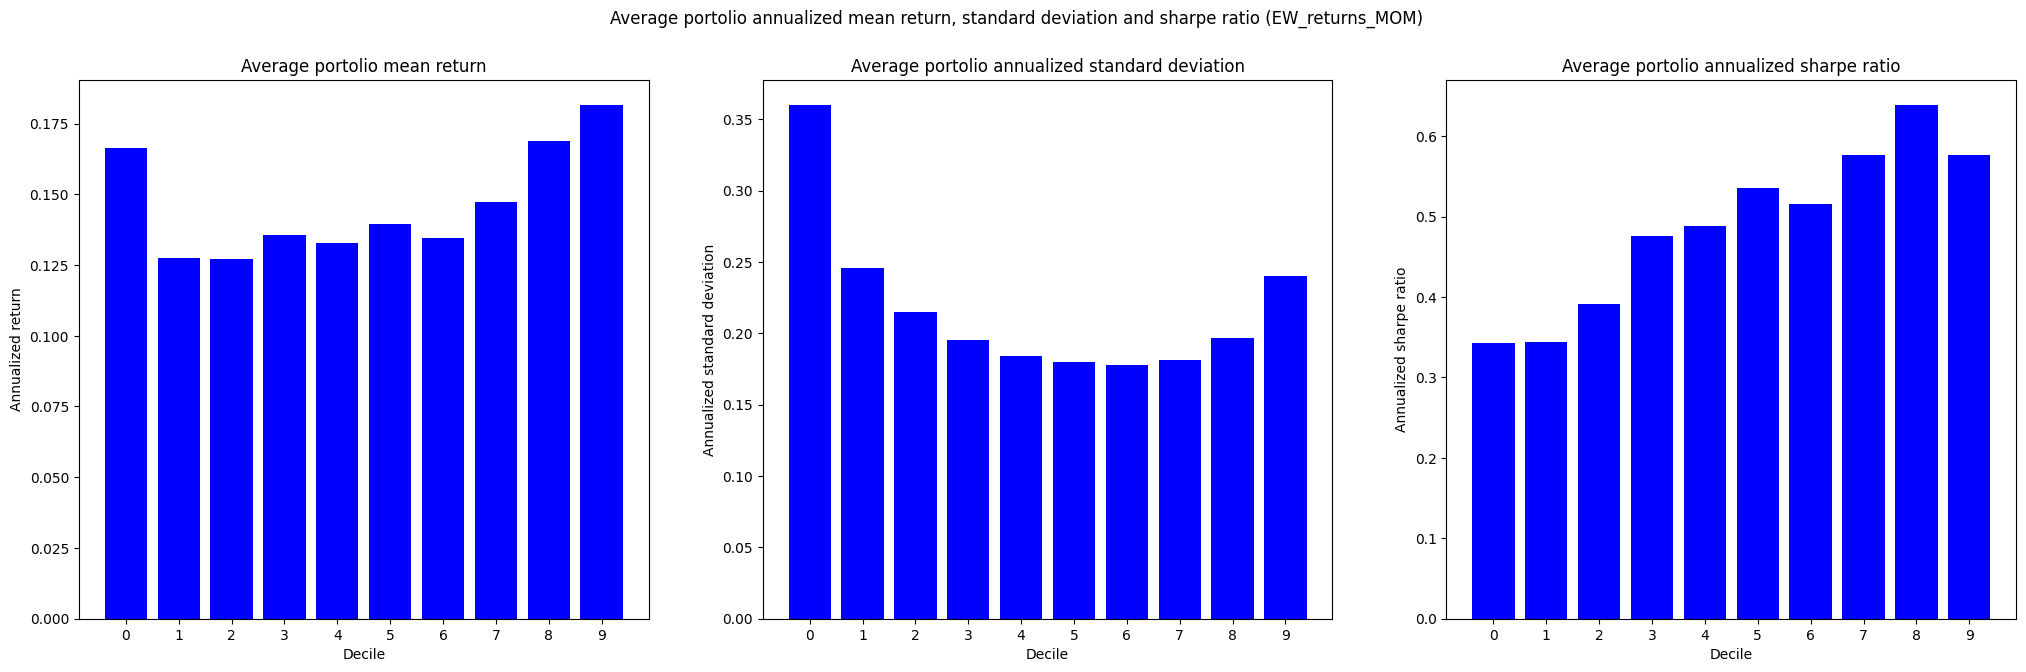

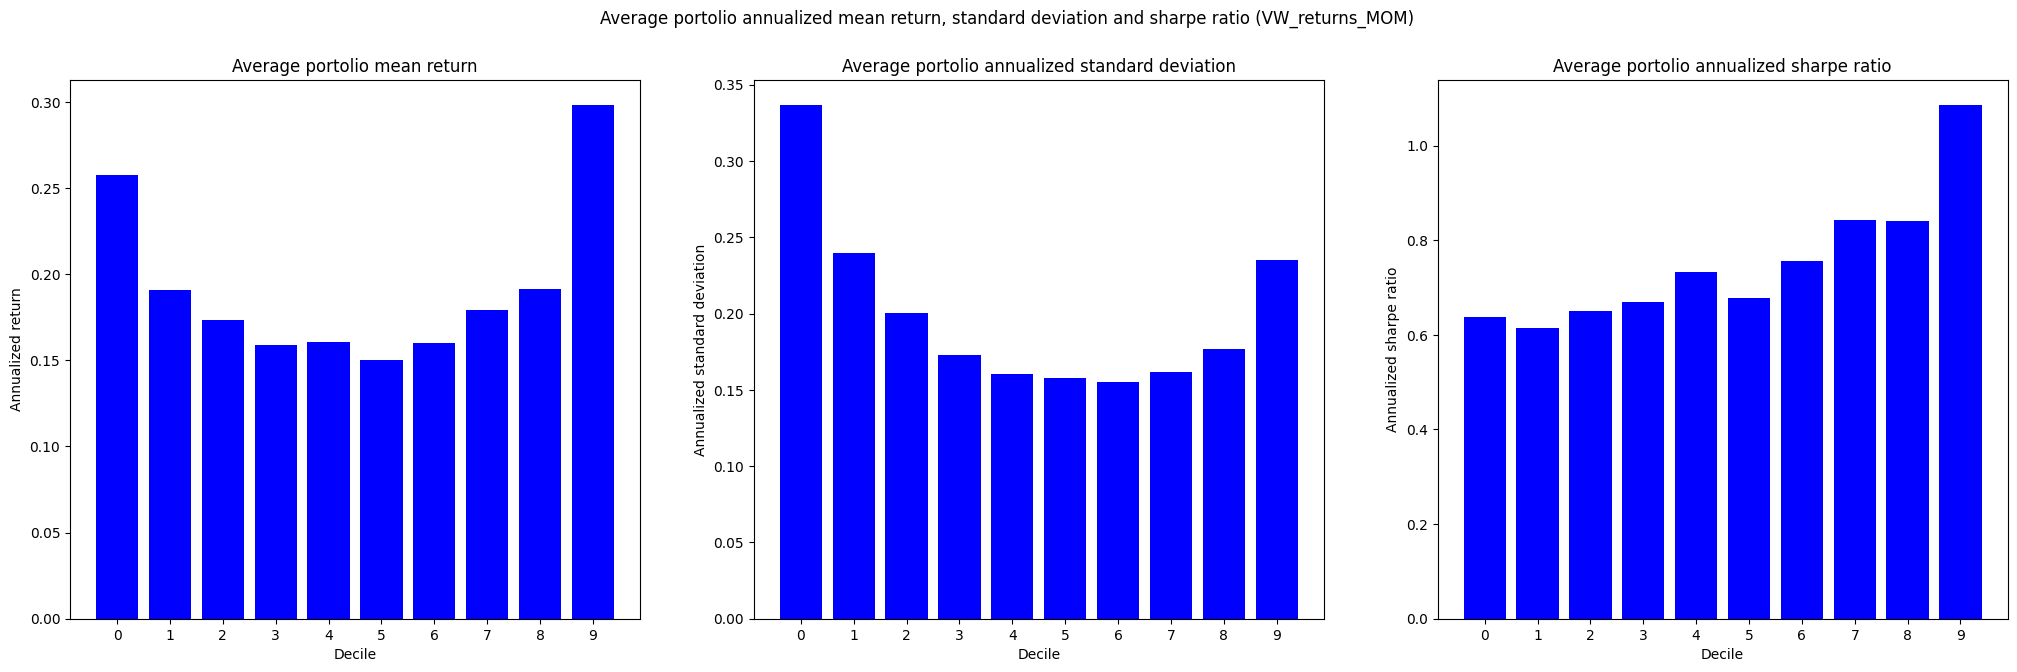

In [138]:
# Plot the results for the 2 different weightings
plot_mean_std_sr(EW_returns_mom, '4a', "EW_returns_MOM")
plot_mean_std_sr(VW_returns_mom, '4a', "VW_returns_MOM")

## Question b)

### Prepare data

In [139]:
# Create a column 'leg' that is 1 if the decile is 7, 8 or 9, and -1 if decile is 0, 1, 2
data_mom['leg'] = np.nan
data_mom.loc[data_mom['decile_mom'] <= 2, 'leg'] = -1
data_mom.loc[data_mom['decile_mom'] >= 7, 'leg'] = 1

# Drop the observations that are in none of the legs
data_mom_b = data_mom.dropna().copy()
display(data_mom_b)

,permno,date,ret,shrout,prc,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,roll_ret,decile_mom,EW_monthly_return,VW_weight,VW_ret_contrib,leg
85,10001,2011-01-31,0.028992,7834.0,10.78,84450.52,86017.32,0.000125,0.019183,0.028867,0.019058,0.145569,2.0,0.027210,0.000055,1.589335e-06,-1.0
81,10001,2011-05-31,0.028050,8151.0,11.50,93736.50,94144.05,0.000036,-0.014948,0.028014,-0.014984,0.105463,2.0,-0.016396,0.000054,1.526084e-06,-1.0
80,10001,2011-06-30,0.008261,8151.0,11.55,94144.05,91128.18,0.000006,-0.018447,0.008255,-0.018453,0.128684,2.0,-0.018676,0.000055,4.560040e-07,-1.0
79,10001,2011-07-29,-0.028139,8151.0,11.18,91128.18,89508.96,0.000074,-0.022534,-0.028213,-0.022608,0.053612,2.0,-0.029904,0.000053,-1.482442e-06,-1.0
66,10001,2012-08-31,-0.012315,8157.0,9.98,81406.86,81080.58,0.000065,0.026317,-0.012380,0.026252,-0.026368,2.0,0.043579,0.000123,-1.519789e-06,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439106,93426,2023-05-31,-0.069792,12577.0,34.92,439188.84,508761.12,0.004129,0.000708,-0.073921,-0.003421,0.270427,8.0,-0.023177,0.000156,-1.089036e-05,1.0
1439104,93426,2023-06-30,0.063860,12577.0,37.15,467235.55,390562.50,0.004302,0.066183,0.059558,0.061881,0.242411,7.0,0.112128,0.000166,1.059465e-05,1.0
1439102,93426,2023-07-31,0.006999,12577.0,37.41,470505.57,409184.52,0.004442,0.035624,0.002557,0.031182,0.235897,7.0,0.038200,0.000162,1.131344e-06,1.0
1439095,93426,2023-11-30,0.019051,12510.0,30.49,381429.90,424932.00,0.004455,0.092057,0.014596,0.087602,-0.276471,2.0,0.084776,0.000199,3.791824e-06,-1.0


### Equally weighted portfolios

In [140]:
# Create a dataframe that aggregates takes the average return for each leg, at each month. Also keep the risk free rate
EW_data_mom = data_mom_b.groupby(['date', 'leg']).agg({
    'ret': 'mean', 
    RF_COL: 'first',
    }).reset_index()

EW_data_mom_piv = EW_data_mom.pivot(index='date', columns='leg', values='ret') # Pivot the data
EW_data_mom_piv['EW_return'] = EW_data_mom_piv[1] - EW_data_mom_piv[-1] # Compute the return of the EW momentum strategy as being the difference between the two legs
EW_data_mom_piv[RF_COL] = EW_data_mom.groupby('date')[RF_COL].first() # Add the risk free rate
EW_data_mom_piv = EW_data_mom_piv[['EW_return', RF_COL]]   # Keep only the relevant columns
# display(EW_data_mom_piv)

# Compute mean, std and Sharpe ratio
mean = EW_data_mom_piv['EW_return'].mean() * 12
std = EW_data_mom_piv['EW_return'].std() * np.sqrt(12)
rf = EW_data_mom_piv[RF_COL].mean() * 12

# Dispay the results
print(colored("Momentum strategy based on equally weighted portfolios", "black", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}%".format(mean))
print(" - Standard deviation:\t {:.2f}%".format(std))
print(" - Sharpe ratio:\t {:.2f}".format((mean - rf)/ std))

Momentum strategy based on equally weighted portfolios
 - Expected return:	 0.03%
 - Standard deviation:	 0.17%
 - Sharpe ratio:	 -0.10


###  Value weighted portfolios

In [141]:
VW_data_mom = data_mom_b.copy()

VW_data_mom['VW_wL'] = (VW_data_mom['leg'] == -1) * VW_data_mom['mcap']
VW_data_mom['VW_wL_sum'] = VW_data_mom.groupby('date')['VW_wL'].transform('sum')
VW_data_mom['VW_wH'] = (VW_data_mom['leg'] == 1) * VW_data_mom['mcap']
VW_data_mom['VW_wH_sum'] = VW_data_mom.groupby('date')['VW_wH'].transform('sum')
VW_data_mom['VW_wL'] = VW_data_mom['VW_wL'] / VW_data_mom['VW_wL_sum']
VW_data_mom['VW_wH'] = VW_data_mom['VW_wH'] / VW_data_mom['VW_wH_sum']
VW_data_mom = VW_data_mom.drop(columns=['VW_wL_sum', 'VW_wH_sum'])
VW_data_mom['VW_w'] = VW_data_mom['VW_wL'] * VW_data_mom['leg'] + VW_data_mom['VW_wH'] * VW_data_mom['leg']
VW_data_mom['VW_ret'] = VW_data_mom['VW_w'] * VW_data_mom['ret']


# Create a dataframe that aggregates the returns, at each month and keep the risk free rate
VW_data_mom_ = VW_data_mom.groupby(['date']).agg({
    'VW_ret': 'sum', 
    RF_COL: 'first',
    }).reset_index()

# display(VW_data_mom_)

# Compute mean, std and Sharpe ratio
mean = VW_data_mom_['VW_ret'].mean() * 12
std = VW_data_mom_['VW_ret'].std() * np.sqrt(12)
rf = VW_data_mom_[RF_COL].mean() * 12

# Dispay the results
print(colored("Momentum strategy based on value weighted portfolios", "black", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}%".format(mean))
print(" - Standard deviation:\t {:.2f}%".format(std))
print(" - Sharpe ratio:\t {:.2f}".format((mean - rf)/ std))

Momentum strategy based on value weighted portfolios
 - Expected return:	 0.01%
 - Standard deviation:	 0.18%
 - Sharpe ratio:	 -0.17


# 5 Idiosyncratic Volatility Strategy (IV)

## Prepare data

In [142]:
data_iv = data_Qb.drop(columns=['VW_weight', 'VW_ret_contrib', 'mcap_l', 'EW_monthly_decile']).copy()
display(data_iv.head())
print(data_iv.shape)

,permno,date,ret,shrout,prc,mcap,tmytm,vwretd,Rn_e,Rm_e,beta
36,10001,2013-01-31,0.062701,8157.0,9.87,80509.59,0.000051,0.054142,0.062650,0.054091,2.152012
37,10001,2013-02-28,0.011651,8157.0,9.94,81080.58,0.000040,0.008282,0.011611,0.008242,2.064342
38,10001,2013-03-28,0.030684,8157.0,10.20,83201.40,0.000034,0.035295,0.030650,0.035261,2.065339
44,10001,2013-09-30,0.004412,10372.0,10.20,105794.40,0.000017,0.037497,0.004395,0.037480,2.084554
48,10001,2014-01-31,0.147572,10452.0,9.17,95844.84,0.000042,-0.030020,0.147530,-0.030062,2.327879


(403313, 11)


## Question a)

Use previously computed rolling betas to compute the residuals of the regression of the stock's excess return against market excess return

In [143]:
# Residuals
data_iv['residuals'] = data_iv['Rn_e'] - (data_iv['beta'] * data_iv['Rm_e'])

# Compute volatility of residuals (idiosyncratic volatility)
data_iv['IV'] = data_iv.groupby('permno')['residuals'].rolling(window=w, min_periods=36).std().reset_index(level=0, drop=True)
data_iv = data_iv.dropna(subset=['IV']).copy()

# Winsorize at 5% and 95% (code from PS5)
data_iv['IV'] = data_iv['IV'].clip(data_iv['IV'].quantile(0.05), data_iv['IV'].quantile(0.95))

data_iv = data_iv.drop(columns=['residuals']) # no need that column anymore

display(data_iv.head())
print(data_iv.shape)

,permno,date,ret,shrout,prc,mcap,tmytm,vwretd,Rn_e,Rm_e,beta,IV
236,10006,1976-04-30,0.012658,5783.0,50.000,289150.000,0.003911,-0.010402,0.008747,-0.014313,0.878247,0.064114
239,10006,1976-07-30,-0.052265,8675.0,34.000,294950.000,0.004235,-0.006136,-0.056500,-0.010371,0.888217,0.063593
241,10006,1976-09-30,0.040892,8675.0,35.000,303625.000,0.004235,0.024513,0.036657,0.020278,0.918600,0.062853
245,10006,1977-01-31,0.014235,8675.0,35.625,309046.875,0.003793,-0.036326,0.010442,-0.040119,0.894098,0.062580
246,10006,1977-02-28,-0.022456,8675.0,34.375,298203.125,0.003691,-0.015744,-0.026147,-0.019435,0.899216,0.061776


(223987, 12)


## Question b)

In [144]:
# Create deciles based on IV
data_iv["IV_decile"] = data_iv.groupby("date")["IV"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

### Equally weighted

In [145]:
# Equally weighted returns per month, for each decile
EW_returns_IV = data_iv.groupby(["date", "IV_decile"]).agg({
    'date': 'first',
    'ret': 'mean',
    RF_COL: 'first',
    'IV_decile': 'first'
    }).reset_index(drop=True).rename(columns={'IV_decile': 'decile'})

print(colored("Equally weighted monthly returns per decile, IV:", "black", attrs=['underline', 'bold']))
display(EW_returns_IV.head(5))
print(EW_returns_IV.shape)

Equally weighted monthly returns per decile, IV:


,date,ret,tmytm,decile
0,1976-04-30,-0.001842,0.003911,0
1,1976-04-30,-0.006933,0.003911,1
2,1976-04-30,-0.001355,0.003911,2
3,1976-04-30,-0.011447,0.003911,3
4,1976-04-30,-0.012108,0.003911,4


(2089, 4)


### Value weighted

In [146]:
# Value weighted returns per month, for each decile
data_iv['VW_weight'] = data_iv.groupby(['date', 'IV_decile'])['mcap'].transform(lambda x: x / x.sum())
data_iv['VW_ret_contrib'] = data_iv['VW_weight'] * data_iv['ret']

VW_returns_IV = data_iv.groupby(["date", "IV_decile"]).agg({
    'date': 'first',
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'IV_decile': 'first',
    }).reset_index(drop=True).rename(columns={'IV_decile': 'decile', 'VW_ret_contrib': 'ret'})

print(colored("Value weighted monthly returns per decile, IV:", "black", attrs=['underline', 'bold']))
display(VW_returns_IV.head(5))
print(VW_returns_IV.shape)

Value weighted monthly returns per decile, IV:


,date,ret,tmytm,decile
0,1976-04-30,-0.011843,0.003911,0
1,1976-04-30,-0.001401,0.003911,1
2,1976-04-30,-0.007150,0.003911,2
3,1976-04-30,0.005520,0.003911,3
4,1976-04-30,-0.001755,0.003911,4


(2089, 4)


### Plot the mean, std, sr

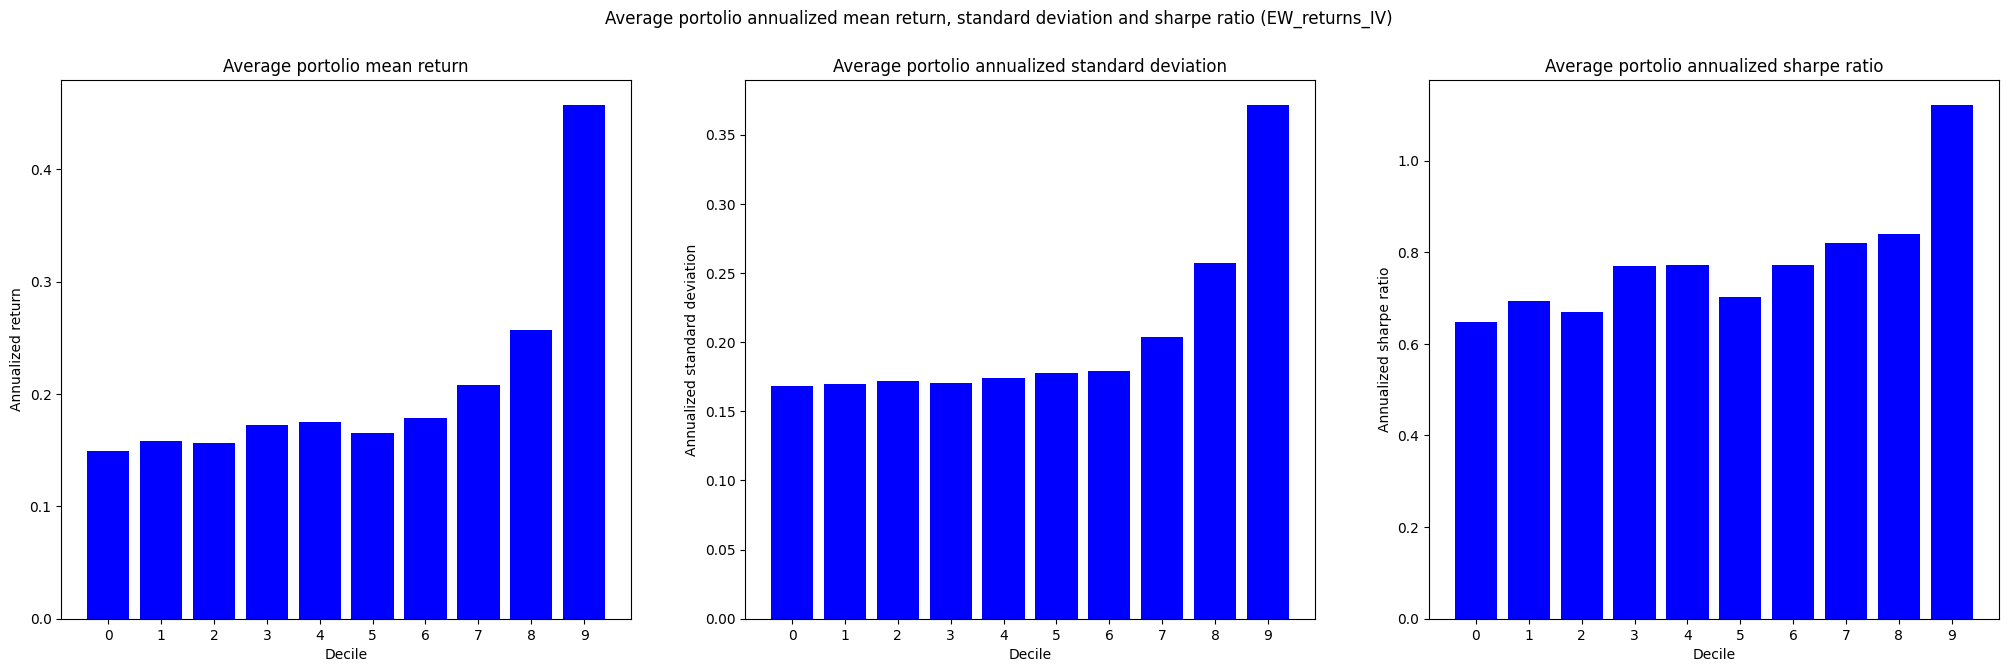

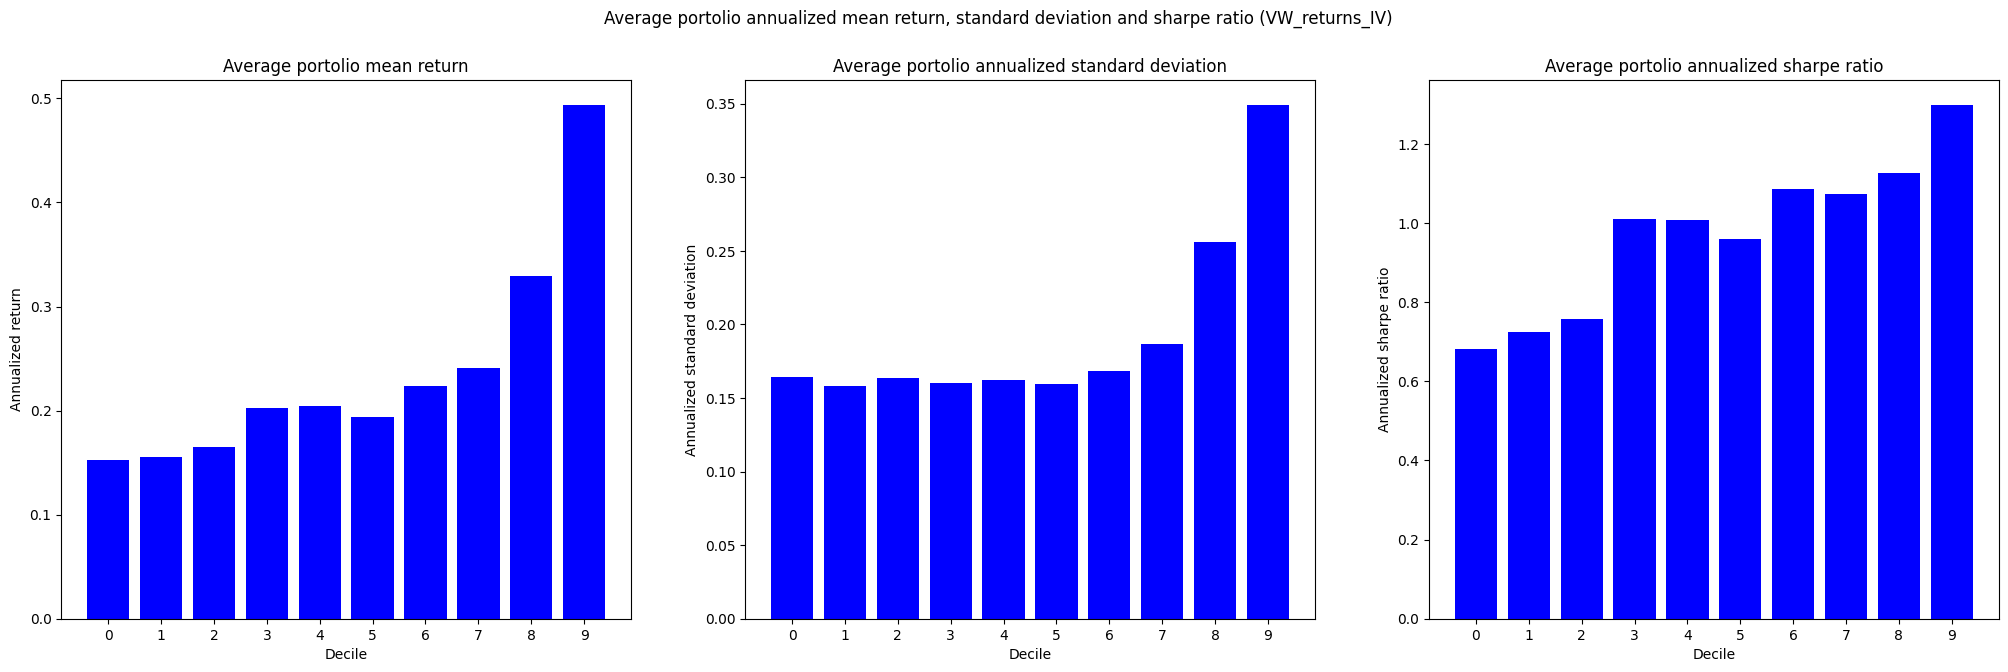

In [147]:
# Plot the results for the 2 different weightings
plot_mean_std_sr(EW_returns_IV, '5b', "EW_returns_IV")
plot_mean_std_sr(VW_returns_IV, '5b', "VW_returns_IV")

## Question c)

### Prepare data

In [148]:
# Create a column 'leg' that is 1 if the decile is 7, 8 or 9, and -1 if decile is 0, 1, 2
data_iv['leg'] = np.nan
data_iv.loc[data_iv['IV_decile'] <= 2, 'leg'] = -1
data_iv.loc[data_iv['IV_decile'] >= 7, 'leg'] = 1

# Drop the observations that are in none of the legs
data_iv_c = data_iv.dropna().copy()

display(data_iv_c.head())
print(data_iv_c.shape)

,permno,date,ret,shrout,prc,mcap,tmytm,vwretd,Rn_e,Rm_e,beta,IV,IV_decile,VW_weight,VW_ret_contrib,leg
236,10006,1976-04-30,0.012658,5783.0,50.000,289150.000,0.003911,-0.010402,0.008747,-0.014313,0.878247,0.064114,1,0.002519,0.000032,-1.0
239,10006,1976-07-30,-0.052265,8675.0,34.000,294950.000,0.004235,-0.006136,-0.056500,-0.010371,0.888217,0.063593,1,0.002419,-0.000126,-1.0
241,10006,1976-09-30,0.040892,8675.0,35.000,303625.000,0.004235,0.024513,0.036657,0.020278,0.918600,0.062853,1,0.003541,0.000145,-1.0
245,10006,1977-01-31,0.014235,8675.0,35.625,309046.875,0.003793,-0.036326,0.010442,-0.040119,0.894098,0.062580,0,0.000972,0.000014,-1.0
246,10006,1977-02-28,-0.022456,8675.0,34.375,298203.125,0.003691,-0.015744,-0.026147,-0.019435,0.899216,0.061776,0,0.000950,-0.000021,-1.0


(134496, 16)


### Equally weighted portfolios

First, compare the performance of each leg

,leg,ret,tmytm
0,-1.0,0.048604,0.003387
1,1.0,0.075813,0.003387


Equally weighted monthly returns per leg, IV:
Leg =  1 if decile is 7, 8, 9 
Leg = -1 if decile is 0, 1, 2


,date,ret,tmytm,leg
0,1976-04-30,-0.003377,0.003911,-1.0
1,1976-04-30,-0.033043,0.003911,1.0
2,1976-07-30,0.001648,0.004235,-1.0
3,1976-07-30,-0.007155,0.004235,1.0
4,1976-09-30,0.020883,0.004235,-1.0


(422, 4)


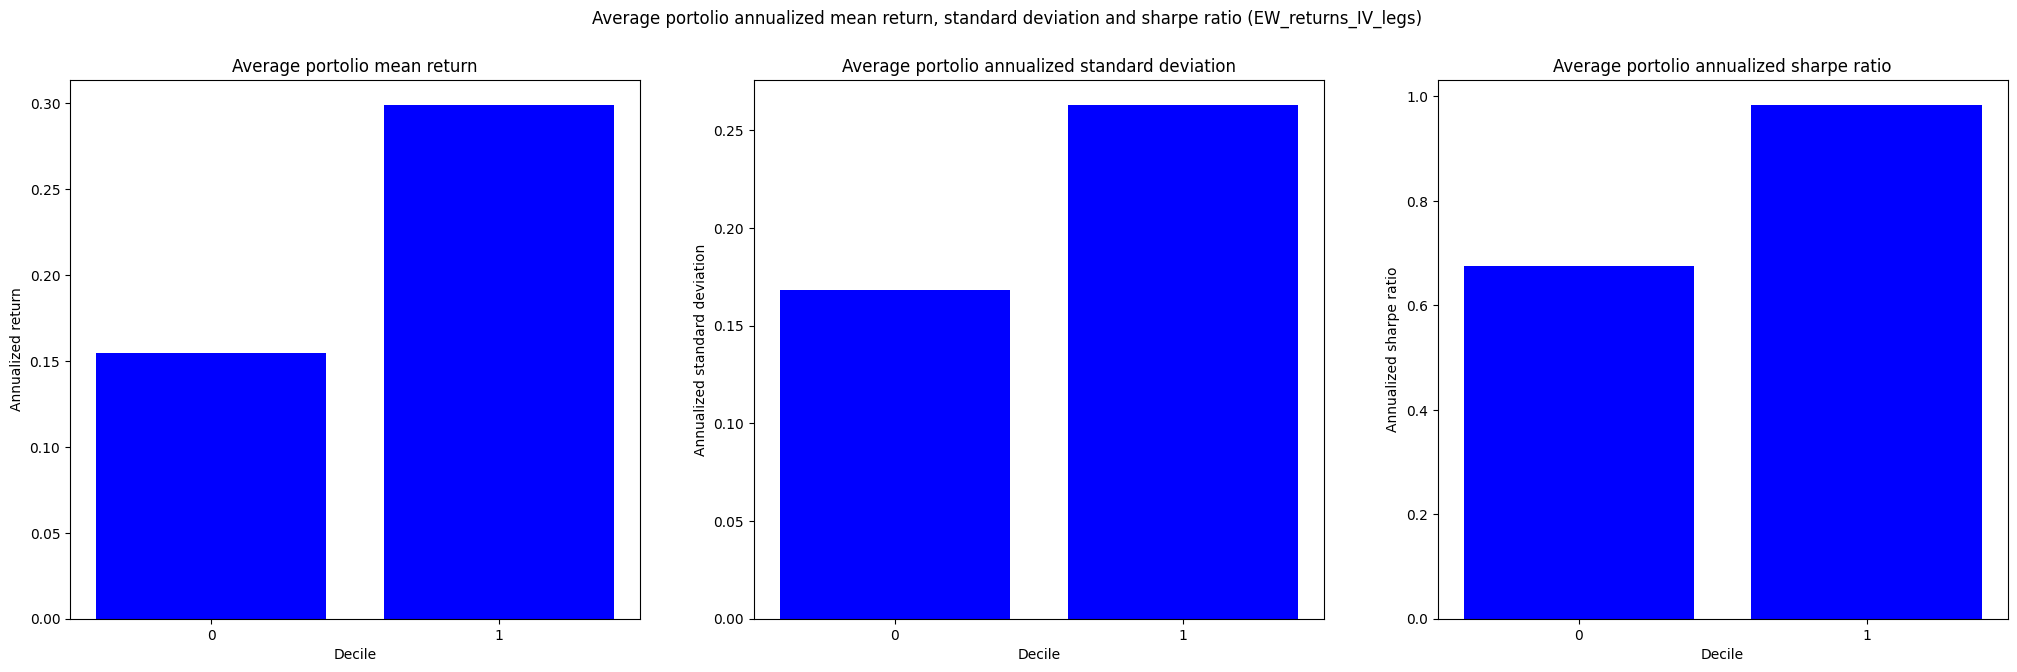

In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.


In [149]:
# Compare the performance of each leg
EW_returns_IV_legs = data_iv_c.groupby(["date", "leg"]).agg({
    'date': 'first',
    'ret': 'mean',
    RF_COL: 'first',
    'leg': 'first'
    }).reset_index(drop=True)

testons = EW_returns_IV_legs.groupby('leg').agg({
    'ret': 'std',
    RF_COL: 'mean'
    }).reset_index()
display(testons)

print(colored("Equally weighted monthly returns per leg, IV:", "black", attrs=['underline', 'bold']))
print("Leg =  1 if decile is 7, 8, 9 \nLeg = -1 if decile is 0, 1, 2")
display(EW_returns_IV_legs.head(5))
print(EW_returns_IV_legs.shape)

# Plot the mean, std, sr
plot_mean_std_sr(EW_returns_IV_legs.rename(columns={'leg': 'decile'}), '5c', "EW_returns_IV_legs")
print("In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.")

Second, display the performance

In [150]:
# Create a dataframe that aggregates takes the average return for each leg, at each month. Also keep the risk free rate
EW_data_IV_leg = data_iv_c.groupby(['date', 'leg']).agg({
    'ret': 'mean', 
    RF_COL: 'first',
    }).reset_index()

EW_data_IV_piv = EW_data_IV_leg.pivot(index='date', columns='leg', values='ret') # Pivot the data
EW_data_IV_piv['EW_return'] = EW_data_IV_piv[1] - EW_data_IV_piv[-1] # Compute the return of the EW momentum strategy as being the difference between the two legs
EW_data_IV_piv[RF_COL] = EW_data_IV_leg.groupby('date')[RF_COL].first() # Add the risk free rate
EW_data_IV_piv = EW_data_IV_piv[['EW_return', RF_COL]]   # Keep only the relevant columns

# Compute mean, std and Sharpe ratio
mean_EW_IV = EW_data_IV_piv['EW_return'].mean() * 12
std_EW_IV = EW_data_IV_piv['EW_return'].std() * np.sqrt(12)
rf_EW_IV = EW_data_IV_piv[RF_COL].mean() * 12

# Dispay the results
print(colored("IV strategy based on equally weighted portfolios", "black", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}".format(mean_EW_IV))
print(" - Standard deviation:\t {:.2f}".format(std_EW_IV))
print(" - Sharpe ratio:\t {:.2f}".format((mean_EW_IV - rf_EW_IV)/ std_EW_IV))

IV strategy based on equally weighted portfolios
 - Expected return:	 0.14
 - Standard deviation:	 0.16
 - Sharpe ratio:	 0.65


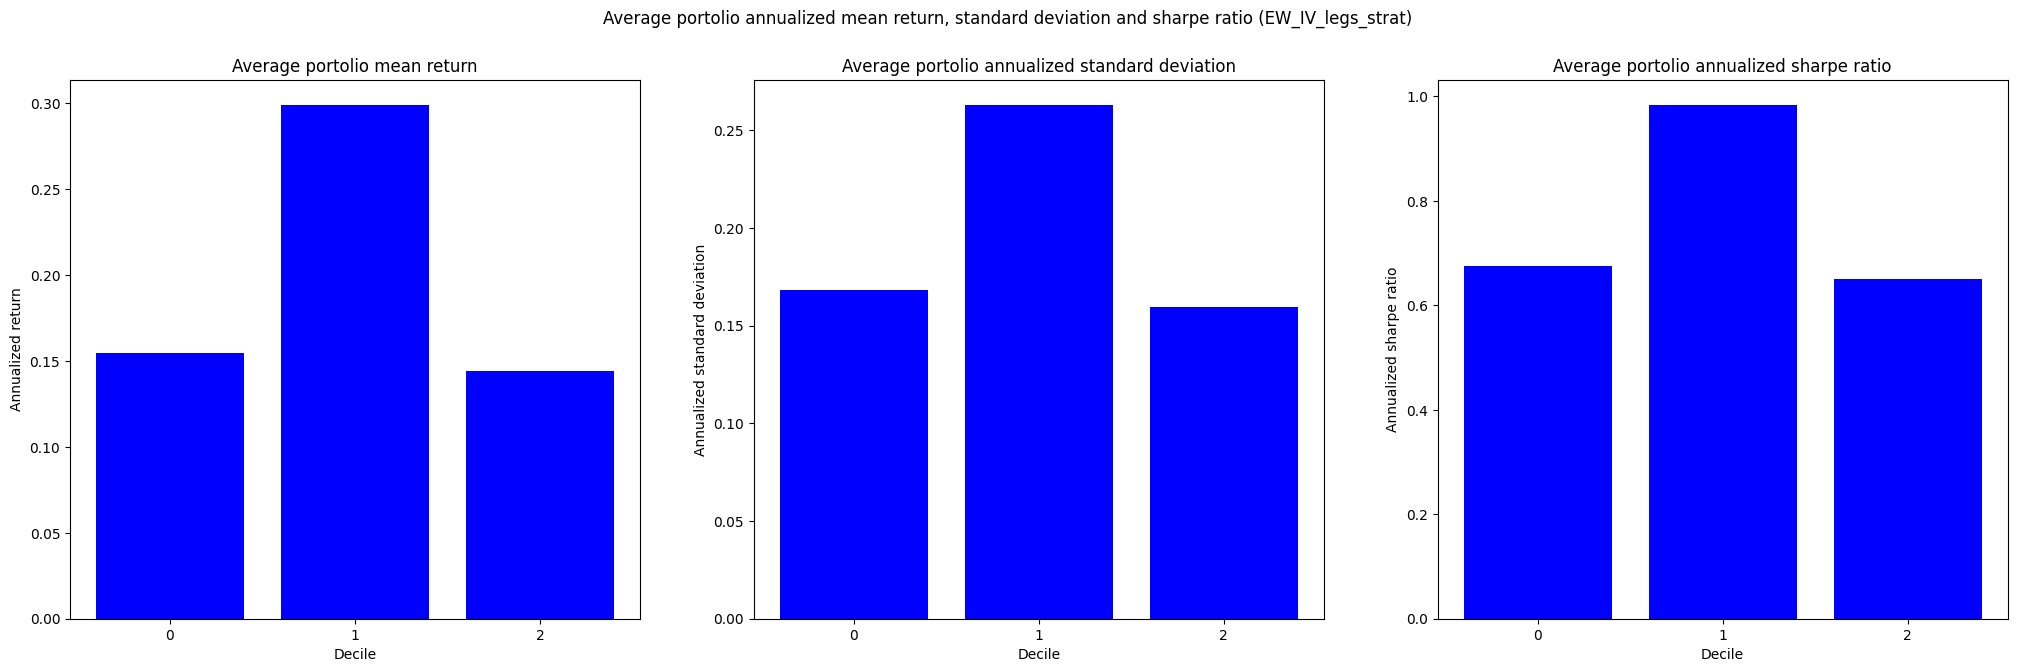

Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy


In [151]:
# Compare the 2 legs and the strategy in a graph
mean, std, sr = get_mean_std_sharpe(EW_returns_IV_legs.rename(columns={'leg': 'decile'}))
mean.append(mean_EW_IV), std.append(std_EW_IV), sr.append((mean_EW_IV - rf_EW_IV)/ std_EW_IV)
# print(mean, std, sr)

plot = plot_from_lists(mean, std, sr, plot_color = 'blue')

plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio (EW_IV_legs_strat)')
plot.savefig(f"Figures/question_5c_plot_EW_IV_legs_strat")
plot.show()
print("Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy")

### t-test

We perform a t-test to determine if the strategy has an average return that is statistically significantly different from zero.

In [152]:
from scipy import stats

In [153]:
t_stat, p_value = stats.ttest_1samp(EW_data_IV_piv['EW_return'], 0)
print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

t-statistic: 3.79, p-value: 0.0002


The null hypothesis can be rejected with a high confidence level, indicating that the strategy is effficient to generate returns.

### Value weighted portfolios

First, compare the performance of each leg.

In [154]:
data_iv

,permno,date,ret,shrout,prc,mcap,tmytm,vwretd,Rn_e,Rm_e,beta,IV,IV_decile,VW_weight,VW_ret_contrib,leg
236,10006,1976-04-30,0.012658,5783.0,50.000,289150.000,0.003911,-0.010402,0.008747,-0.014313,0.878247,0.064114,1,0.002519,0.000032,-1.0
239,10006,1976-07-30,-0.052265,8675.0,34.000,294950.000,0.004235,-0.006136,-0.056500,-0.010371,0.888217,0.063593,1,0.002419,-0.000126,-1.0
241,10006,1976-09-30,0.040892,8675.0,35.000,303625.000,0.004235,0.024513,0.036657,0.020278,0.918600,0.062853,1,0.003541,0.000145,-1.0
245,10006,1977-01-31,0.014235,8675.0,35.625,309046.875,0.003793,-0.036326,0.010442,-0.040119,0.894098,0.062580,0,0.000972,0.000014,-1.0
246,10006,1977-02-28,-0.022456,8675.0,34.375,298203.125,0.003691,-0.015744,-0.026147,-0.019435,0.899216,0.061776,0,0.000950,-0.000021,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420777,93426,2022-12-30,-0.047326,12551.0,38.650,485096.150,0.003326,-0.057120,-0.050652,-0.060446,0.758405,0.077961,2,0.000198,-0.000009,-1.0
1420779,93426,2023-02-28,0.009727,12551.0,43.600,547223.600,0.003682,-0.024666,0.006045,-0.028348,0.761749,0.077021,2,0.000222,0.000002,-1.0
1420783,93426,2023-06-30,0.063860,12577.0,37.150,467235.550,0.004302,0.066183,0.059558,0.061881,0.756221,0.076102,2,0.000181,0.000012,-1.0
1420785,93426,2023-08-31,-0.037156,12581.0,36.020,453167.620,0.004463,-0.020605,-0.041619,-0.025068,0.761621,0.075453,2,0.000179,-0.000007,-1.0


In [155]:
data_iv_leg = data_iv.copy()

# Value weighted returns per month, for each decile
data_iv_leg['VW_weight'] = data_iv_leg.groupby(['date', 'leg'])['mcap'].transform(lambda x: x / x.sum())
data_iv_leg['VW_ret_contrib'] = data_iv_leg['VW_weight'] * data_iv_leg['ret']

VW_returns_IV_leg = data_iv.groupby(["date", "IV_decile"]).agg({
    'date': 'first',
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'IV_decile': 'first',
    }).reset_index(drop=True).rename(columns={'IV_decile': 'decile', 'VW_ret_contrib': 'ret'})

print(colored("Value weighted monthly returns per decile, IV:", "black", attrs=['underline', 'bold']))
display(VW_returns_IV.head(5))
print(VW_returns_IV.shape)

Value weighted monthly returns per decile, IV:


,date,ret,tmytm,decile
0,1976-04-30,-0.011843,0.003911,0
1,1976-04-30,-0.001401,0.003911,1
2,1976-04-30,-0.007150,0.003911,2
3,1976-04-30,0.005520,0.003911,3
4,1976-04-30,-0.001755,0.003911,4


(2089, 4)


,date,leg,ret,tmytm
0,1976-04-30,-1.0,-0.008304,0.003911
1,1976-04-30,1.0,-0.027012,0.003911
2,1976-07-30,-1.0,-0.003851,0.004235
3,1976-07-30,1.0,-0.013374,0.004235
4,1976-09-30,-1.0,0.025940,0.004235
...,...,...,...,...
417,2023-06-30,1.0,0.103844,0.004302
418,2023-08-31,-1.0,-0.020841,0.004463
419,2023-08-31,1.0,-0.004264,0.004463
420,2023-11-30,-1.0,0.086439,0.004455


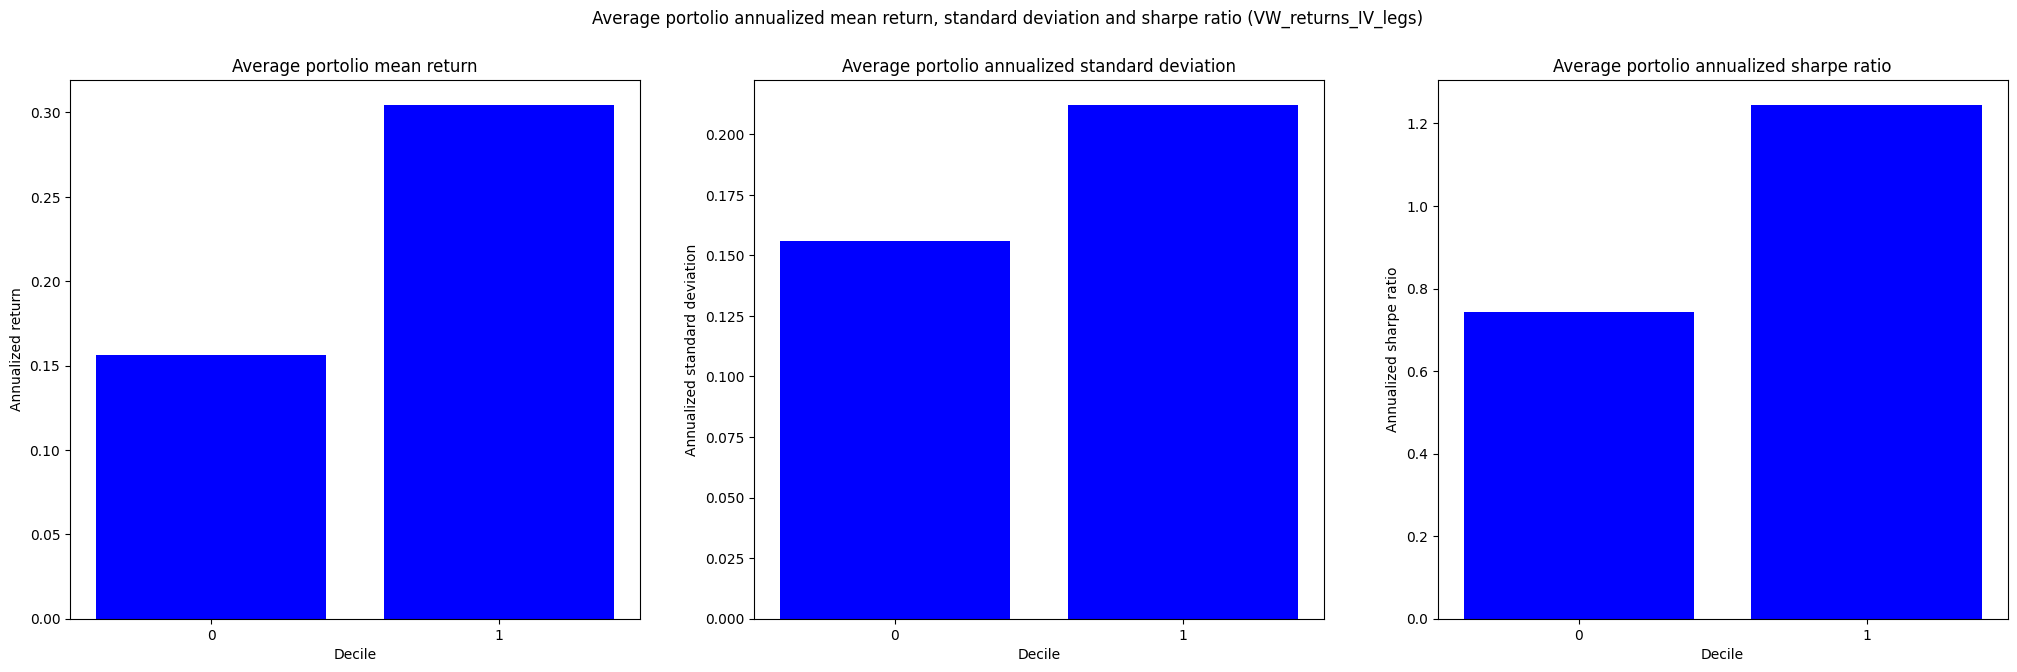

In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.


In [156]:
# Re-use the dataframe from earlier question, we already computed the VW contribution
VW_data_IV = data_iv_c.copy()

# Value weighted returns per month, for each decile
VW_data_IV['VW_weight'] = VW_data_IV.groupby(['date', 'leg'])['mcap'].transform(lambda x: x / x.sum())
VW_data_IV['VW_ret_contrib'] = VW_data_IV['VW_weight'] * VW_data_IV['ret']

VW_returns_IV_legs = VW_data_IV.groupby(['date', 'leg']).agg({
    'VW_ret_contrib': 'sum', 
    RF_COL: 'first',
    }).rename(columns={'VW_ret_contrib': 'ret'}).reset_index()

display(VW_returns_IV_legs)

# Plot the mean, std, sr
plot_mean_std_sr(VW_returns_IV_legs.rename(columns={'leg': 'decile'}), '5c', "VW_returns_IV_legs")
print("In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.")

leg,VW_return,tmytm
date,,
1976-04-30,-0.018709,0.003911
1976-07-30,-0.009523,0.004235
1976-09-30,-0.003976,0.004235
1977-01-31,0.067231,0.003793
1977-02-28,-0.000813,0.003691
...,...,...
2022-12-30,-0.025541,0.003326
2023-02-28,-0.003326,0.003682
2023-06-30,0.031790,0.004302


IV strategy based on value weighted portfolios
 - Expected return:	 0.15
 - Standard deviation:	 0.13
 - Sharpe ratio:	 0.82


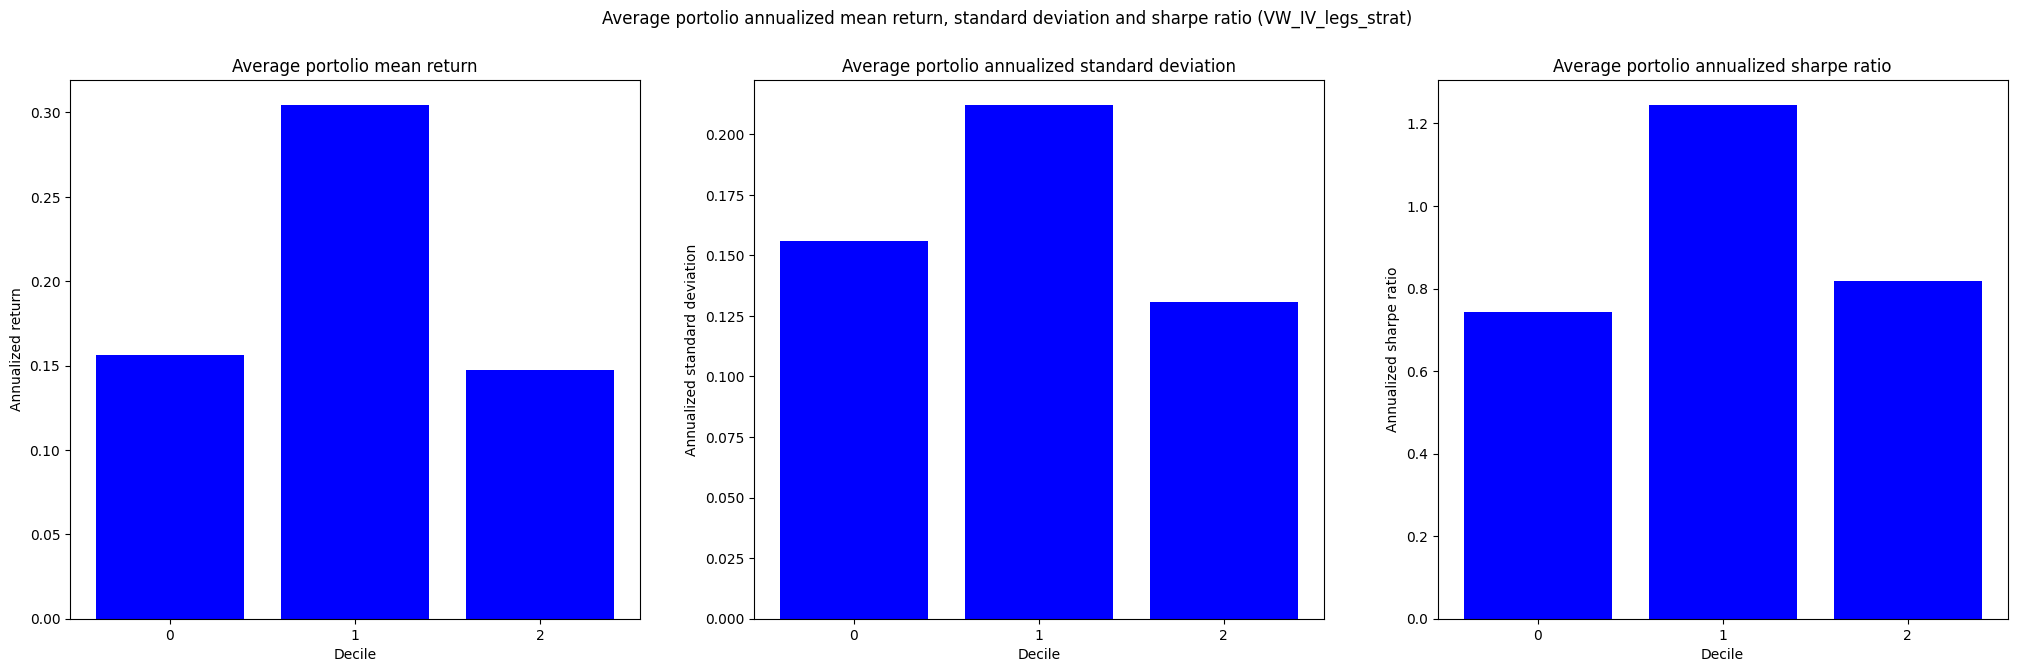

Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy


In [157]:
# We use the same methodolgy as before to compute the return of the strategy
VW_data_IV_piv = VW_returns_IV_legs.pivot(index='date', columns='leg', values='ret') # Pivot the data
VW_data_IV_piv['VW_return'] = VW_data_IV_piv[1] - VW_data_IV_piv[-1] # Compute the return of the VW momentum strategy as being the difference between the two legs
VW_data_IV_piv[RF_COL] = VW_returns_IV_legs.groupby('date')[RF_COL].first() # Add the risk free rate
VW_data_IV_piv = VW_data_IV_piv[['VW_return', RF_COL]]   # Keep only the relevant columns
display(VW_data_IV_piv)

# Compute mean, std and Sharpe ratio
mean_VW_IV = VW_data_IV_piv['VW_return'].mean() * 12
std_VW_IV = VW_data_IV_piv['VW_return'].std() * np.sqrt(12)
rf_VW_IV = VW_data_IV_piv[RF_COL].mean() * 12

# Dispay the results
print(colored("IV strategy based on value weighted portfolios", "black", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}".format(mean_VW_IV))
print(" - Standard deviation:\t {:.2f}".format(std_VW_IV))
print(" - Sharpe ratio:\t {:.2f}".format((mean_VW_IV - rf_VW_IV)/ std_VW_IV))

# Compare the 2 legs and the strategy in a graph
mean, std, sr = get_mean_std_sharpe(VW_returns_IV_legs.rename(columns={'leg': 'decile'}))
mean.append(mean_VW_IV), std.append(std_VW_IV), sr.append((mean_VW_IV - rf_VW_IV)/ std_VW_IV)
# print(mean, std, sr)

plot = plot_from_lists(mean, std, sr, plot_color = 'blue')

plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio (VW_IV_legs_strat)')
plot.savefig(f"Figures/question_5c_plot_VW_IV_legs_strat")
plot.show()
print("Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy")

### t-test

We perform a t-test to determine if the strategy has an average return that is statistically significantly different from zero.

In [158]:
t_stat, p_value = stats.ttest_1samp(VW_data_IV_piv['VW_return'], 0)
print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.7f}")


t-statistic: 4.73, p-value: 0.0000041


The evidence is even higher than before, providing strong confidence against the null hypothesis. The long-short strategy mean return is significantly different from zero.

# 6 Optimal Fund Portfolio Return (STRAT)

We only consider the value weighted portfolios from the previous strategies.

In [159]:
VOL_TARGET = 0.1

## Prepare data

In [160]:
# First we prepare the data
dataBAB = data_BAB[['date', 'rBAB']].copy()
dataMOM = VW_data_mom_[['date', 'VW_ret', RF_COL]].rename(columns={'VW_ret':'rMOM'}).copy()
dataIV = VW_data_IV_piv.rename(columns={'VW_return':'rIV'}).copy().reset_index()

In [161]:
# Merge the data
dataSTRAT = pd.merge(dataBAB, dataMOM, on='date', how='inner')
dataSTRAT = pd.merge(dataSTRAT, dataIV[['date', 'rIV']], on='date', how='inner')
dataSTRAT= dataSTRAT[['date', RF_COL, 'rBAB', 'rMOM', 'rIV']]
display(dataSTRAT.head())
print(dataSTRAT.shape)

,date,tmytm,rBAB,rMOM,rIV
0,1976-04-30,0.003911,-0.076325,-0.005510,-0.018709
1,1976-07-30,0.004235,-0.041529,-0.013360,-0.009523
2,1976-09-30,0.004235,0.025767,-0.001567,-0.003976
3,1977-01-31,0.003793,0.040531,0.067093,0.067231
4,1977-02-28,0.003691,-0.036341,-0.017732,-0.000813


(211, 5)


In [162]:
# Function to compute the mean, std and Sharpe ratio of the STRAT strategies
def get_mean_std_sharpe_STRAT(data, return_col:str):
    mean = data[return_col].mean() * 12
    std = data[return_col].std() * np.sqrt(12)
    rf = data[RF_COL].mean() * 12
    sr = (mean - rf) / std
    return mean, std, sr

## Equal weight strategies

The return of STRAT is the the weighted average of the returns of the 3 strategies

In [163]:
# Compute the STRAT return
dataSTRAT_EW = dataSTRAT.copy()
dataSTRAT_EW['rSTRAT_EW'] = (dataSTRAT_EW['rBAB'] + dataSTRAT_EW['rMOM'] + dataSTRAT_EW['rIV']) / 3
dataSTRAT_EW.head()

,date,tmytm,rBAB,rMOM,rIV,rSTRAT_EW
0,1976-04-30,0.003911,-0.076325,-0.005510,-0.018709,-0.033515
1,1976-07-30,0.004235,-0.041529,-0.013360,-0.009523,-0.021471
2,1976-09-30,0.004235,0.025767,-0.001567,-0.003976,0.006741
3,1977-01-31,0.003793,0.040531,0.067093,0.067231,0.058285
4,1977-02-28,0.003691,-0.036341,-0.017732,-0.000813,-0.018295


In [164]:
# Determining the c constant for each year
dataSTRAT_EW['rSTRATstd'] = dataSTRAT_EW.groupby(dataSTRAT_EW.date.dt.year)['rSTRAT_EW'].transform('std') * np.sqrt(12)
dataSTRAT_EW['C'] = 0.1 / dataSTRAT_EW['rSTRATstd']
dataSTRAT_EW['rFUND_EW'] = dataSTRAT_EW['C'] * dataSTRAT_EW['rSTRAT_EW'] + dataSTRAT_EW[RF_COL]

display(dataSTRAT_EW.head())
print(dataSTRAT_EW.shape)

,date,tmytm,rBAB,rMOM,rIV,rSTRAT_EW,rSTRATstd,C,rFUND_EW
0,1976-04-30,0.003911,-0.076325,-0.005510,-0.018709,-0.033515,0.071575,1.397128,-0.042913
1,1976-07-30,0.004235,-0.041529,-0.013360,-0.009523,-0.021471,0.071575,1.397128,-0.025763
2,1976-09-30,0.004235,0.025767,-0.001567,-0.003976,0.006741,0.071575,1.397128,0.013653
3,1977-01-31,0.003793,0.040531,0.067093,0.067231,0.058285,0.133634,0.748315,0.047408
4,1977-02-28,0.003691,-0.036341,-0.017732,-0.000813,-0.018295,0.133634,0.748315,-0.010000


(211, 9)


In [165]:
retSTRAT_EW, stdSTRAT_EW, srSTRAT_EW = get_mean_std_sharpe_STRAT(dataSTRAT_EW, 'rFUND_EW')

print(colored("STRAT strategy based on equally weighted portfolios", attrs=['underline', 'bold'])) 
print(" - Expected return:\t {:.2f}".format(retSTRAT_EW))
print(" - Standard deviation:\t {:.2f}".format(stdSTRAT_EW))
print(" - Sharpe ratio:\t {:.2f}".format(srSTRAT_EW))

STRAT strategy based on equally weighted portfolios
 - Expected return:	 0.19
 - Standard deviation:	 0.13
 - Sharpe ratio:	 1.15


## Risk-parity based approach

We determine the weights of BAB, MOM, IV under a risk parity approach, based on the rolling estimate of their return std over the last 36 months (excluding last).

In [166]:
# For the risk parity, we use the rolling 3-year monthly volatility
dataSTRAT_RP = dataSTRAT.copy()

dataSTRAT_RP['rBABstd'] = dataSTRAT_RP['rBAB'].rolling(window=36, min_periods=36, closed='left').std() * np.sqrt(12)
dataSTRAT_RP['rMOMstd'] = dataSTRAT_RP['rMOM'].rolling(window=36, min_periods=36, closed='left').std() * np.sqrt(12)
dataSTRAT_RP['rIVstd'] = dataSTRAT_RP['rIV'].rolling(window=36, min_periods=36, closed='left').std()   * np.sqrt(12)
dataSTRAT_RP.dropna(inplace=True)

dataSTRAT_RP['rSTRAT'] = dataSTRAT_RP['rBAB']/dataSTRAT_RP['rBABstd'] + dataSTRAT_RP['rMOM']/dataSTRAT_RP['rMOMstd'] + dataSTRAT_RP['rIV']/dataSTRAT_RP['rIVstd']

dataSTRAT_RP.head()


,date,tmytm,rBAB,rMOM,rIV,rBABstd,rMOMstd,rIVstd,rSTRAT
36,1984-02-29,0.007408,-0.078860,0.032718,-0.023601,0.284144,0.132266,0.124411,-0.219875
37,1984-04-30,0.007719,-0.033676,0.008111,0.002353,0.284470,0.131902,0.125072,-0.038074
38,1984-08-31,0.008933,0.195566,-0.087878,0.030145,0.283836,0.130741,0.124036,0.259880
39,1984-11-30,0.006172,-0.079626,-0.001517,-0.029364,0.299583,0.144076,0.122551,-0.515930
40,1985-01-31,0.006377,0.194934,-0.072748,0.065837,0.306650,0.141150,0.124942,0.647240


In [167]:
# Determining the c constant for each year
dataSTRAT_RP['rSTRATstd'] = dataSTRAT_RP.groupby(dataSTRAT_RP.date.dt.year)['rSTRAT'].transform('std') * np.sqrt(12)
dataSTRAT_RP['C'] = 0.1 / dataSTRAT_RP['rSTRATstd']
dataSTRAT_RP['rFUND_RP'] = dataSTRAT_RP['C'] * dataSTRAT_RP['rSTRAT'] + dataSTRAT_RP[RF_COL]

display(dataSTRAT_RP.head())
print(dataSTRAT_RP.shape)

,date,tmytm,rBAB,rMOM,rIV,rBABstd,rMOMstd,rIVstd,rSTRAT,rSTRATstd,C,rFUND_RP
36,1984-02-29,0.007408,-0.078860,0.032718,-0.023601,0.284144,0.132266,0.124411,-0.219875,1.126885,0.088740,-0.012103
37,1984-04-30,0.007719,-0.033676,0.008111,0.002353,0.284470,0.131902,0.125072,-0.038074,1.126885,0.088740,0.004340
38,1984-08-31,0.008933,0.195566,-0.087878,0.030145,0.283836,0.130741,0.124036,0.259880,1.126885,0.088740,0.031995
39,1984-11-30,0.006172,-0.079626,-0.001517,-0.029364,0.299583,0.144076,0.122551,-0.515930,1.126885,0.088740,-0.039612
40,1985-01-31,0.006377,0.194934,-0.072748,0.065837,0.306650,0.141150,0.124942,0.647240,1.983769,0.050409,0.039004


(175, 12)


In [168]:
retSTRAT_RP, stdSTRAT_RP, srSTRAT_RP = get_mean_std_sharpe_STRAT(dataSTRAT_RP, 'rFUND_RP')

print(colored("STRAT strategy based on equally risk parity portfolios", attrs=['underline', 'bold'])) 
print(" - Expected return:\t {:.2f}".format(retSTRAT_RP))
print(" - Standard deviation:\t {:.2f}".format(stdSTRAT_RP))
print(" - Sharpe ratio:\t {:.2f}".format(srSTRAT_RP))

STRAT strategy based on equally risk parity portfolios
 - Expected return:	 0.13
 - Standard deviation:	 0.12
 - Sharpe ratio:	 0.85


## Mean-variance optimal combination

In [180]:
from scipy.optimize import minimize

In [181]:
# Calculate mean-variance optimal weights
def mean_variance_weights(mean_returns, cov_matrix, RF_COL):
    num_assets = len(mean_returns)
    
    # Calculate portfolio volatility given weights
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Minimize the negative Sharpe ratio = maximize positive Sharpe ratio
    def negative_sharpe_ratio(weights):
        port_return = np.dot(weights, mean_returns)
        port_volatility = portfolio_volatility(weights)
        return -(port_return - RF_COL) / port_volatility
    
    # Weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Common initial guess for weights (equal weights)
    init_guess = num_assets * [1. / num_assets]
    
    result = minimize(negative_sharpe_ratio, init_guess, constraints=constraints)
    
   
    return result.x




In [182]:
# We use the rolling 3-year monthly volatility
dataSTRAT_MV = dataSTRAT.copy()


# Rolling mean and covariance
mean_MV = dataSTRAT_MV[['rBAB', 'rIV', 'rMOM']].rolling(window=36, min_periods=36, closed='left').mean() 
covariance_MV = dataSTRAT_MV[['rBAB', 'rIV', 'rMOM']].rolling(window=36, min_periods=36, closed='left').cov() 

dataSTRAT_MV.dropna(inplace=True)

dataSTRAT_MV.head()


,date,tmytm,rBAB,rMOM,rIV
0,1976-04-30,0.003911,-0.076325,-0.005510,-0.018709
1,1976-07-30,0.004235,-0.041529,-0.013360,-0.009523
2,1976-09-30,0.004235,0.025767,-0.001567,-0.003976
3,1977-01-31,0.003793,0.040531,0.067093,0.067231
4,1977-02-28,0.003691,-0.036341,-0.017732,-0.000813


In [183]:
optimal_weights_list = []
portfolio_returns = []

# Calculate optimal weights and portfolio returns for each rolling window
for i in range(36, len(dataSTRAT_MV)):
    rolling_mean = mean_MV.iloc[i].values
    rolling_cov = covariance_MV.iloc[i*3:(i+1)*3].values.reshape(3, 3)
    
    optimal_weights = mean_variance_weights(rolling_mean, rolling_cov, dataSTRAT_MV[RF_COL].iloc[i])
    optimal_weights_list.append(optimal_weights)
    
    # Calculate portfolio return for the current period
    portfolio_return = np.dot(optimal_weights, dataSTRAT_MV[['rBAB', 'rIV', 'rMOM']].iloc[i].values)
    portfolio_returns.append(portfolio_return)

# Store the results 
dataSTRAT_MV = dataSTRAT_MV.iloc[36:].copy()
dataSTRAT_MV['optimal_weights'] = optimal_weights_list
dataSTRAT_MV['rSTRAT_MV'] = portfolio_returns


# Annualize the statistics
mean_return_MV = np.mean(portfolio_returns) * 12
std_dev_MV = np.std(portfolio_returns) * np.sqrt(12)
sharpe_ratio_MV = (mean_return_MV - dataSTRAT_MV[RF_COL].mean() * 12) / std_dev_MV

# Determine the c constant for each year
dataSTRAT_MV['rSTRATstd'] = dataSTRAT_MV.groupby(dataSTRAT_MV.date.dt.year)['rSTRAT_MV'].transform('std') * np.sqrt(12)
dataSTRAT_MV['C'] = 0.1 / dataSTRAT_MV['rSTRATstd']
dataSTRAT_MV['rFUND_MV'] = dataSTRAT_MV['C'] * dataSTRAT_MV['rSTRAT_MV'] + dataSTRAT_MV[RF_COL]

display(dataSTRAT_MV.head())
print(dataSTRAT_MV.shape)

,date,tmytm,rBAB,rMOM,rIV,optimal_weights,rSTRAT_MV,rSTRATstd,C,rFUND_MV
36,1984-02-29,0.007408,-0.078860,0.032718,-0.023601,"[-0.34597802261181243, 1.3829385127455127, -0....",-0.006564,0.062871,1.590569,-0.003033
37,1984-04-30,0.007719,-0.033676,0.008111,0.002353,"[-0.329897003694444, 1.3007158345983199, 0.029...",0.014407,0.062871,1.590569,0.030634
38,1984-08-31,0.008933,0.195566,-0.087878,0.030145,"[-0.3267959202905655, 1.2941145320779741, 0.03...",-0.027772,0.062871,1.590569,-0.035240
39,1984-11-30,0.006172,-0.079626,-0.001517,-0.029364,"[-0.2669097650986516, 1.3445959407493797, -0.0...",-0.018112,0.062871,1.590569,-0.022637
40,1985-01-31,0.006377,0.194934,-0.072748,0.065837,"[-0.2983057661874041, 1.379594125354629, -0.08...",0.038593,0.101134,0.988788,0.044537


(175, 10)


In [184]:
retSTRAT_MV, stdSTRAT_MV, srSTRAT_MV = get_mean_std_sharpe_STRAT(dataSTRAT_MV, 'rFUND_MV')

print(colored("STRAT strategy based on mean-variance optimal combination", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}".format(retSTRAT_MV))
print(" - Standard deviation:\t {:.2f}".format(stdSTRAT_MV))
print(" - Sharpe ratio:\t {:.2f}".format(srSTRAT_MV))

STRAT strategy based on mean-variance optimal combination
 - Expected return:	 0.13
 - Standard deviation:	 0.11
 - Sharpe ratio:	 0.89
